In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('../data/train_data.csv')
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
train_target = pd.read_csv('../data/train_targets.csv')
train_target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
test = pd.read_csv('../data/test_set_values.csv')
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### I'm going to combine the train_data and train_label dataframes so I have a complete training set with the target label.

In [5]:
train = train_data.merge(train_target, on='id', how='inner')

In [6]:
test_copy = test.copy()

In [7]:
train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### I am going to try using the Missing Indicator function

In [12]:
X = train.drop(columns=['status_group'])
y = train.status_group
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
indicator = MissingIndicator(features='all')
indicator.fit(X_train)

MissingIndicator(error_on_new=True, features='all', missing_values=nan,
         sparse='auto')

In [14]:
def add_missing_indicator_columns(X, indicator):
    """
    Helper function for transforming features
    
    For every feature in X, create another feature indicating whether that feature
    is missing.  This doubles the number of columns in X.
    """
    
    # create a 2D array of True and False values indicating whether a given feature
    # is missing for that row
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [15]:
X_train = add_missing_indicator_columns(X_train, indicator)

In [16]:
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type_missing,water_quality_missing,quality_group_missing,quantity_missing,quantity_group_missing,source_missing,source_type_missing,source_class_missing,waterpoint_type_missing,waterpoint_type_group_missing
24947,33935,20.0,2011-03-08,Government Of Tanzania,330,Ce,38.123839,-6.087137e+00,Ccm,0,...,0,0,0,0,0,0,0,0,0,0
22630,49654,0.0,2013-02-16,Dwsp,0,DWE,0.000000,-2.000000e-08,Mwamahonza,0,...,0,0,0,0,0,0,0,0,0,0
13789,39287,0.0,2011-08-13,Dasip,0,DASIP,33.312321,-2.814100e+00,Chanongu,0,...,0,0,0,0,0,0,0,0,0,0
15697,60510,0.0,2013-01-20,Government Of Tanzania,1542,GOVERNMENT,34.783049,-4.842093e+00,Zahanati,0,...,0,0,0,0,0,0,0,0,0,0
22613,24259,0.0,2013-09-03,World Bank,523,Government,34.660944,-1.070733e+01,Kwa Mzee Charles,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
numeric_feature_names = ['amount_tsh', 'gps_height', 'longitude',
                        'latitude', 'population',
                        'construction_year']
categorical_feature_names = ['funder', 'installer', 'basin', 'region', 
               'region_code', 'district_code', 'lga', 'public_meeting',
               'scheme_management', 'permit', 'construction_year', 
               'extraction_type', 'extraction_type_group', 
               'extraction_type_class', 'management', 'management_group',
               'payment', 'payment_type', 'water_quality', 'quality_group',
               'quantity', 'quantity_group', 'source', 'source_type',
               'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [24]:
X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

In [25]:
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)

In [26]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer.fit(X_train_categorical)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

In [27]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [28]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)a

In [29]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

amount_tsh               0
gps_height               0
longitude                0
latitude                 0
population               0
construction_year        0
funder                   0
installer                0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [30]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [31]:
X_train.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,...,payment_type_missing,water_quality_missing,quality_group_missing,quantity_missing,quantity_group_missing,source_missing,source_type_missing,source_class_missing,waterpoint_type_missing,waterpoint_type_group_missing
24947,20.0,330.0,38.123839,-6.087137e+00,80.0,1972.0,Government Of Tanzania,Ce,Wami / Ruvu,Pwani,...,0,0,0,0,0,0,0,0,0,0
22630,0.0,0.0,0.000000,-2.000000e-08,0.0,0.0,Dwsp,DWE,Lake Victoria,Mwanza,...,0,0,0,0,0,0,0,0,0,0
13789,0.0,0.0,33.312321,-2.814100e+00,0.0,0.0,Dasip,DASIP,Lake Victoria,Mwanza,...,0,0,0,0,0,0,0,0,0,0
15697,0.0,1542.0,34.783049,-4.842093e+00,23.0,2010.0,Government Of Tanzania,GOVERNMENT,Internal,Singida,...,0,0,0,0,0,0,0,0,0,0
22613,0.0,523.0,34.660944,-1.070733e+01,1.0,2013.0,World Bank,Government,Lake Nyasa,Ruvuma,...,0,0,0,0,0,0,0,0,0,0


In [45]:
def countplot_boxplot(column, dataframe):
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(column, size=20)
    
    ax1 = fig.add_subplot(2,1,1)
    sns.countplot(dataframe[column])
    plt.xticks(rotation=45)
    ax2 = fig.add_subplot(2,1,2)
    sns.boxplot(dataframe[column])
    plt.xticks(rotation=45)
    plt.show()
    
    print('Min:', dataframe[column].min())
    print('Mean:', dataframe[column].mean())
    print('Median:', dataframe[column].median())
    print('Mode:', dataframe[column].mode()[0])
    print('Max:', dataframe[column].max())
    print('**********************')
    print('% of values missing:', (dataframe[column].isna().sum() / len(dataframe))*100)

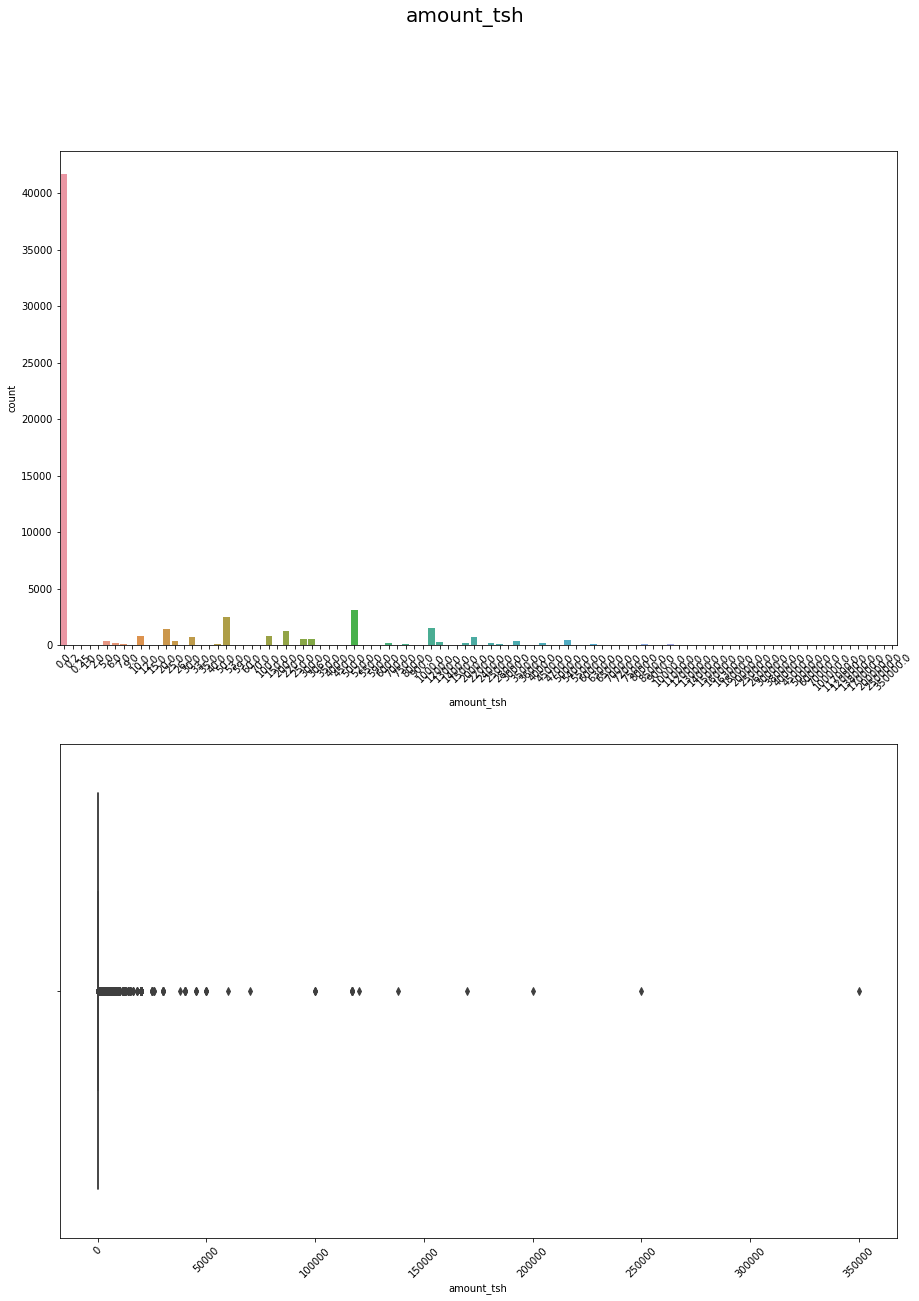

Min: 0.0
Mean: 317.6503846801347
Median: 0.0
Mode: 0.0
Max: 350000.0
**********************
% of values missing: 0.0


In [51]:
countplot_boxplot('amount_tsh', )